# Processing model results

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import xarray as xr
import statsmodels.api as sm

%matplotlib inline
plt.rcParams.update({'font.size': 24})

import seaborn as sns
sns.set()

### USDA: add state trends to county data

In [21]:
# Load USDA data
usda_county = pd.read_csv("../usda_yields/output/USDA_county_yields.csv")

In [22]:
# Calculate county production
usda_county["production"] = usda_county["Value"] * usda_county["area"]

In [23]:
# Get state-level production
usda_state = usda_county.groupby(["state_fips_code", "year"]).sum().drop(columns = ["county_code", "GEOID", "asd_code", "Value", "area"])

In [24]:
usda_state.head()

production
state_fips_code year            
1               1950  56802100.0
                1951  47522700.0
                1952  26978300.0
                1953  50662300.0
                1954  30791400.0

In [25]:
# Get county production shares per state
usda_all = pd.merge(usda_county, usda_state, on = ["year", "state_fips_code"], how = "outer", suffixes=("", "_y"))
usda_all["county_production_share_in_state"] = usda_all["production"] / usda_all["production_y"]
del usda_all["production_y"]

In [26]:
usda_all.head()

,GEOID,year,state_fips_code,county_code,asd_code,Value,area,production,county_production_share_in_state
0,100140,1950,1,1,40,17.0,29600.0,503200.0,0.008859
1,101140,1950,1,11,40,11.0,24200.0,266200.0,0.004686
2,104740,1950,1,47,40,13.0,44200.0,574600.0,0.010116
3,105140,1950,1,51,40,23.0,38900.0,894700.0,0.015751
4,106340,1950,1,63,40,16.0,23900.0,382400.0,0.006732


In [27]:
# Get state yields from county yields weighted by production
usda_all["state_yield"] = usda_all["Value"] * usda_all["county_production_share_in_state"]
usda_state = usda_all.groupby(["state_fips_code", "year"]).sum().drop(columns = ["GEOID", "county_code", "Value", "area", "asd_code", "production", "county_production_share_in_state"])

In [28]:
usda_state.head()

state_yield
state_fips_code year             
1               1950    24.381012
                1951    21.730127
                1952    12.469826
                1953    23.371898
                1954    14.037017

In [29]:
# Add logs
usda_state["Log_yield"] = usda_state.apply(lambda x: np.log(x["state_yield"]) if x["state_yield"] > 0.0 else 0.0, axis = 1)

In [30]:
# Re-index
usda_state = usda_state.reset_index()
usda_state["state_fips_code"] = usda_state["state_fips_code"].astype(str).str.zfill(2)
usda_state.set_index(["state_fips_code", "year"], inplace = True)

In [31]:
# Lowess filter from Statsmodels
lowess = sm.nonparametric.lowess
usda_state["lowess_log_yield"] = 0.0

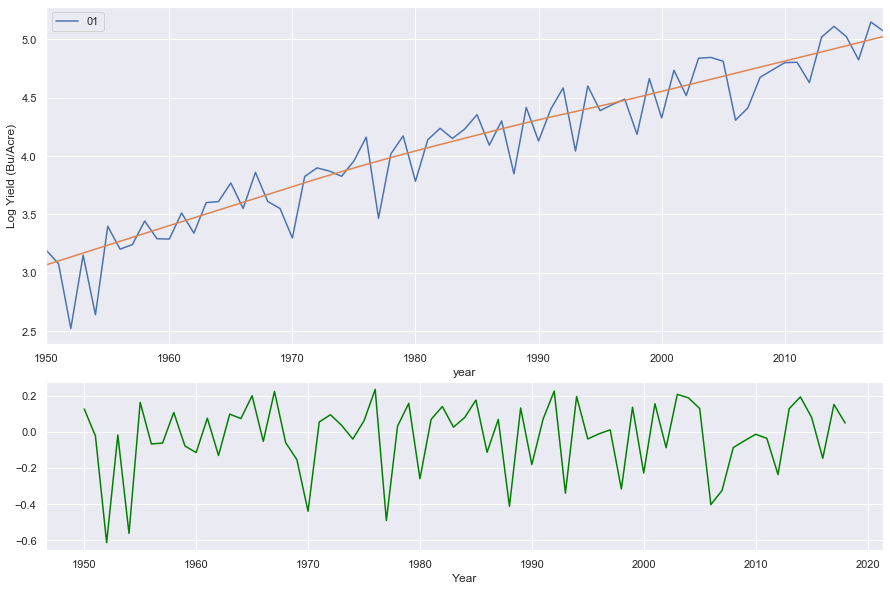

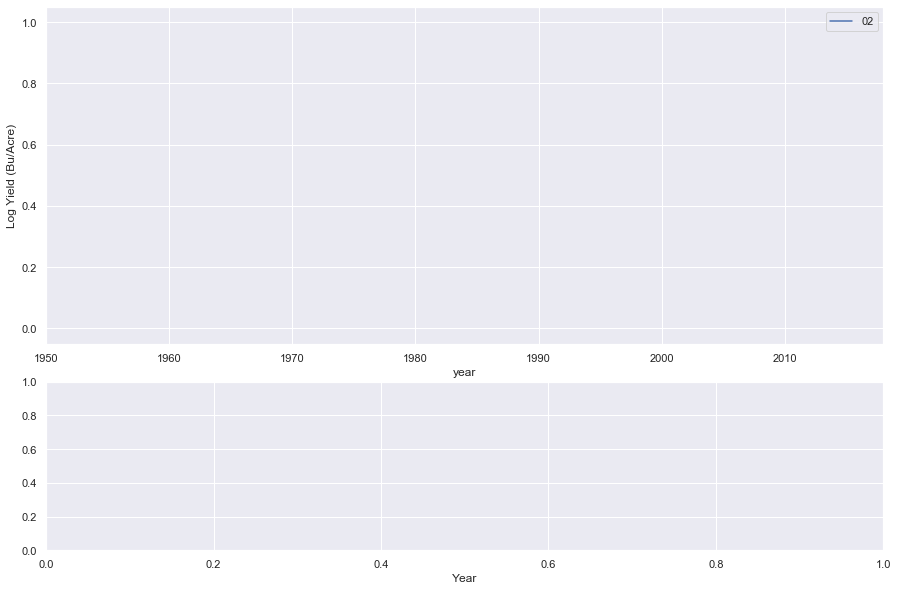

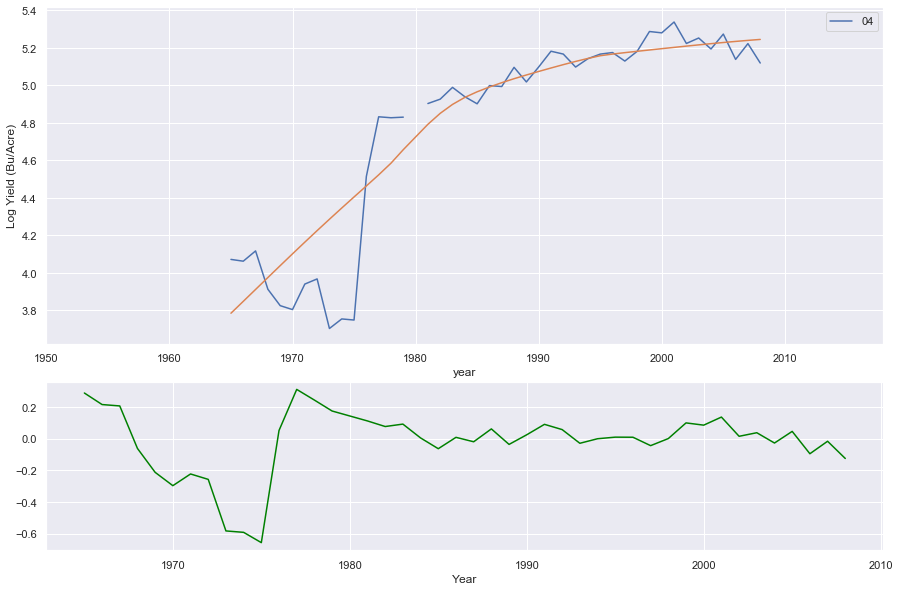

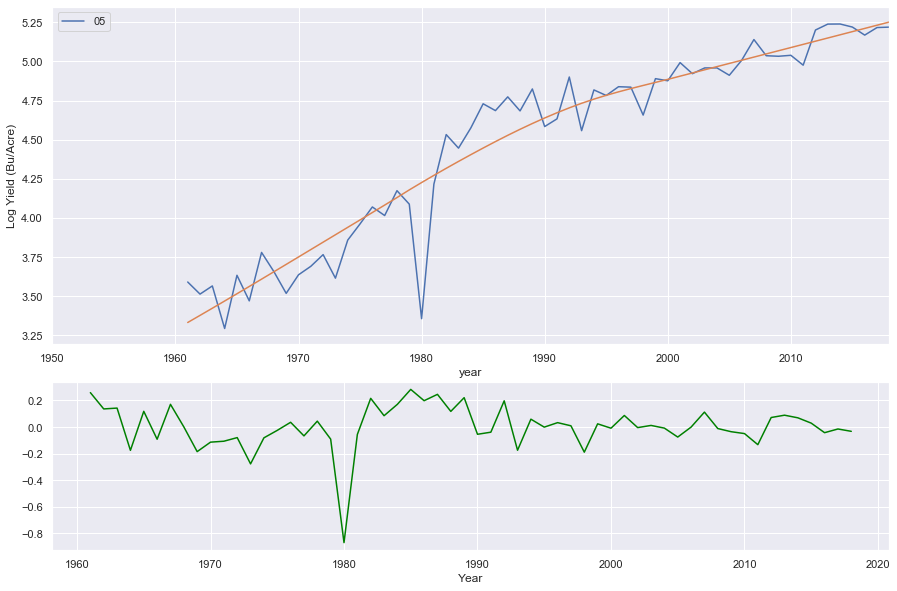

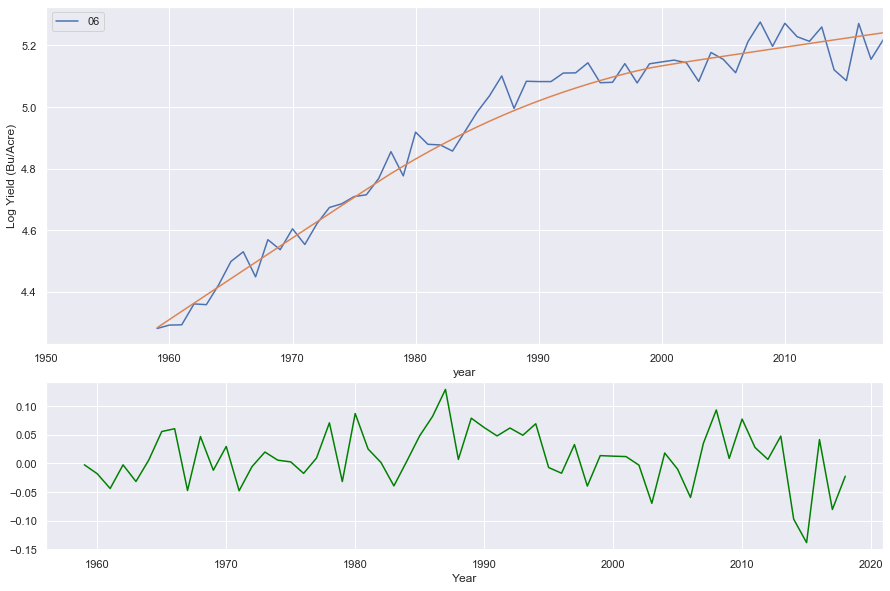

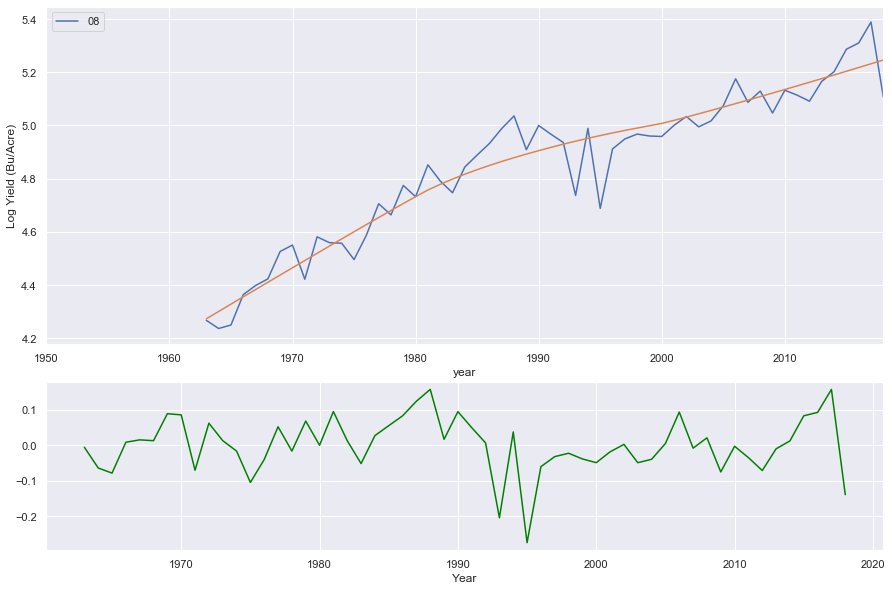

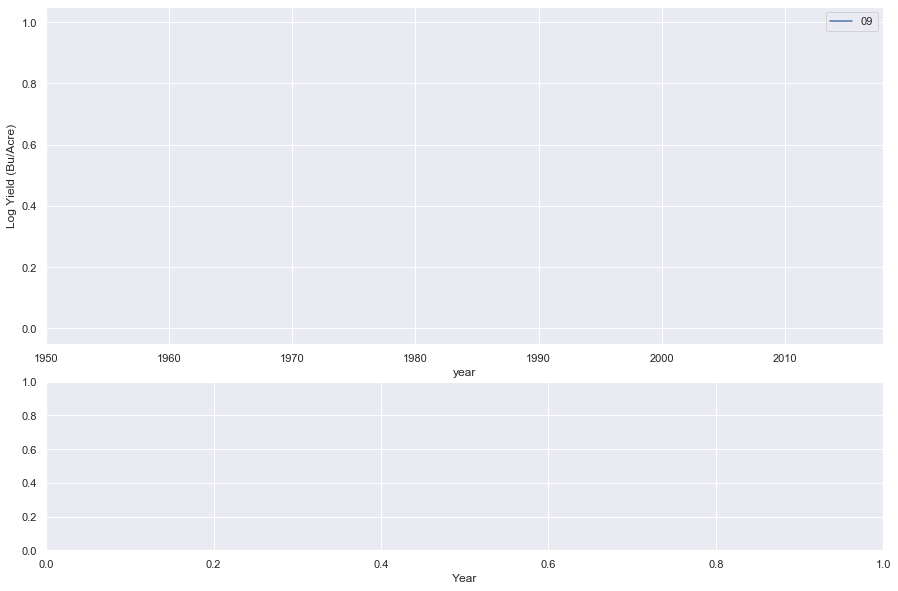

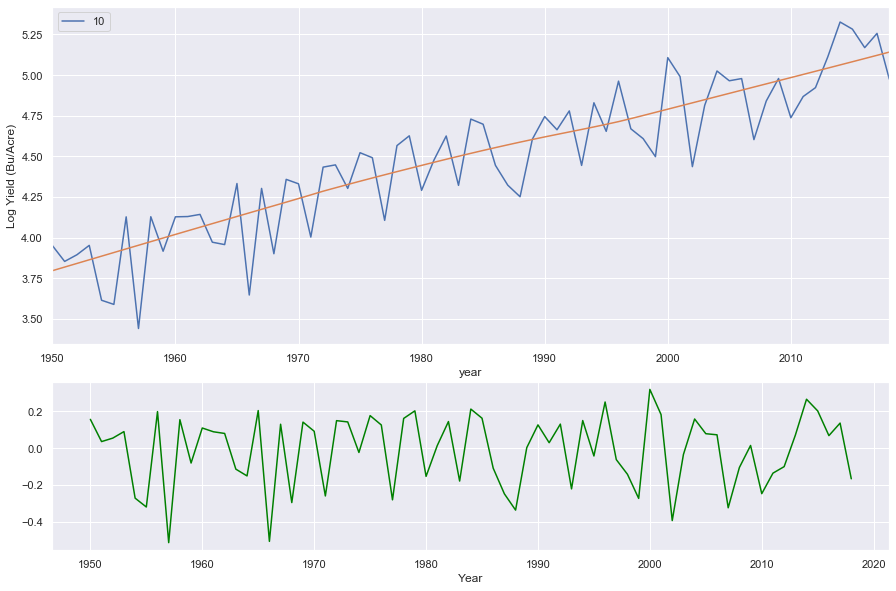

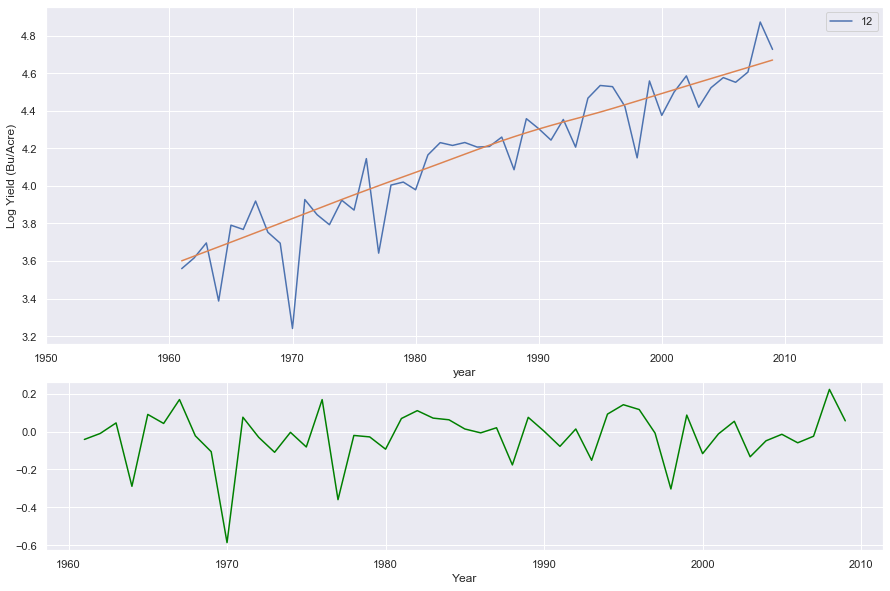

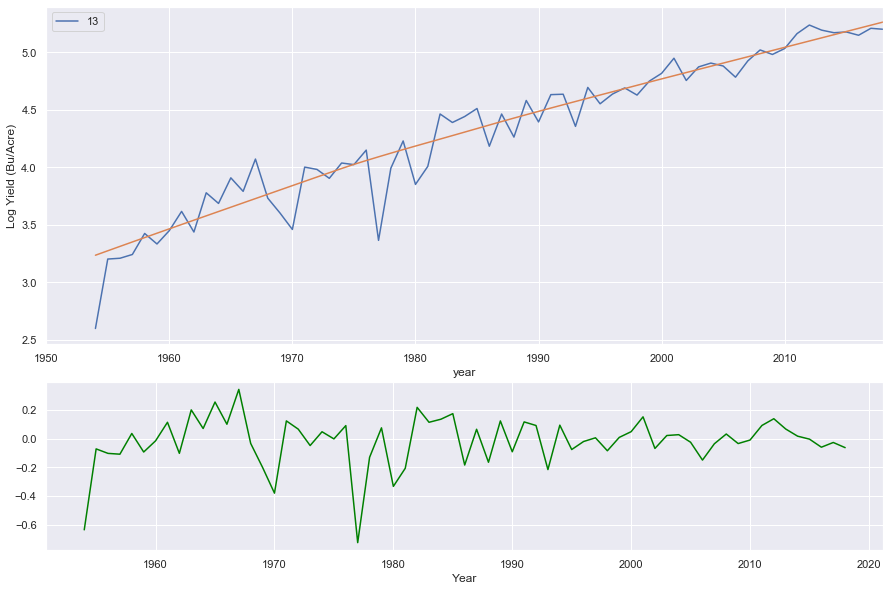

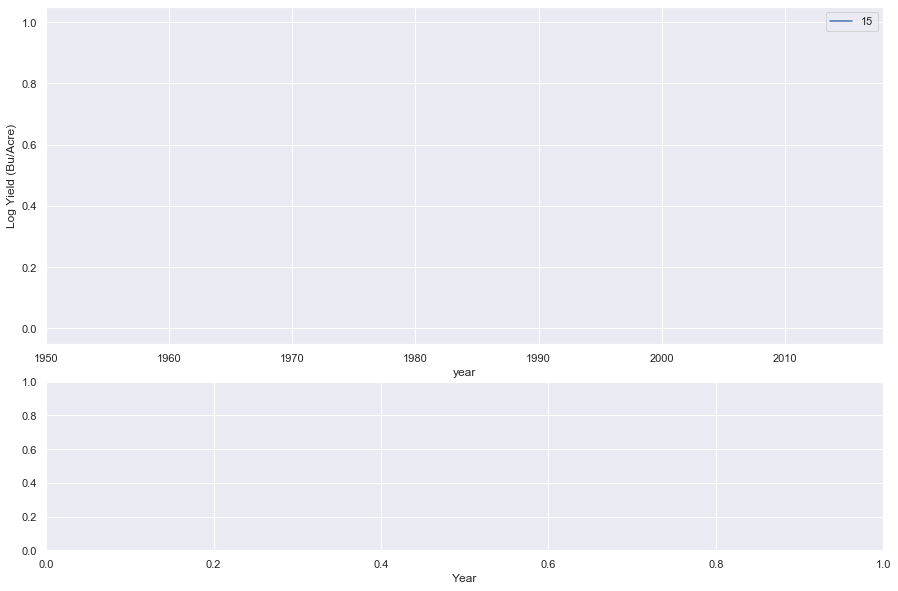

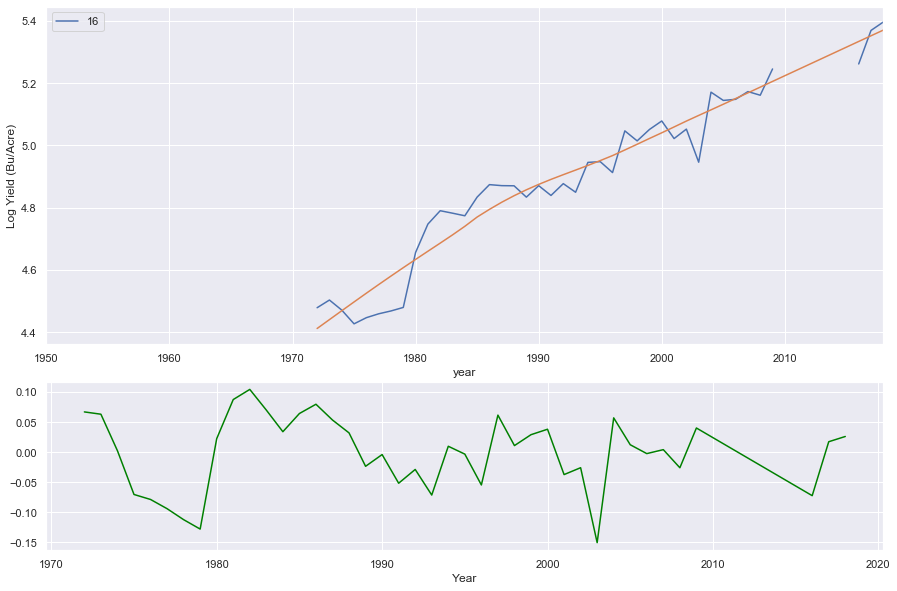

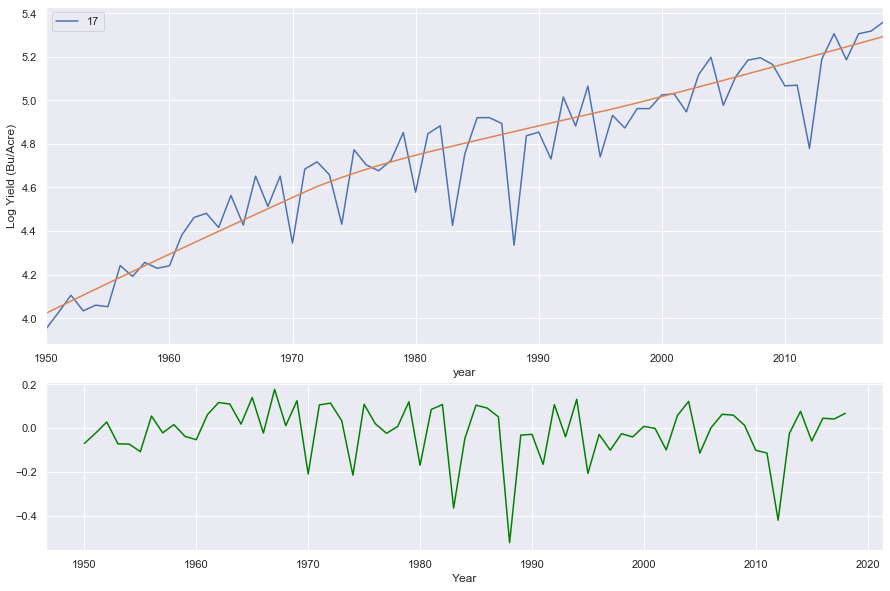

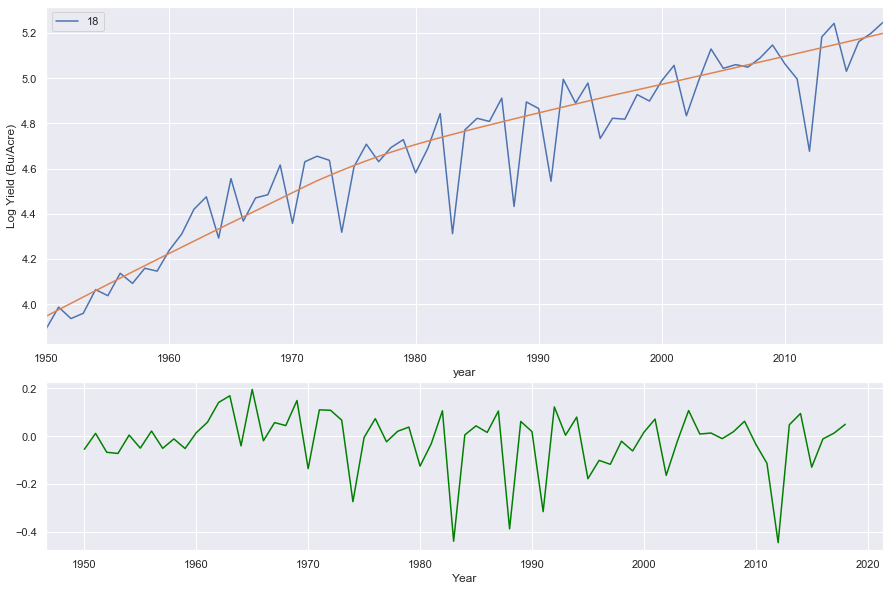

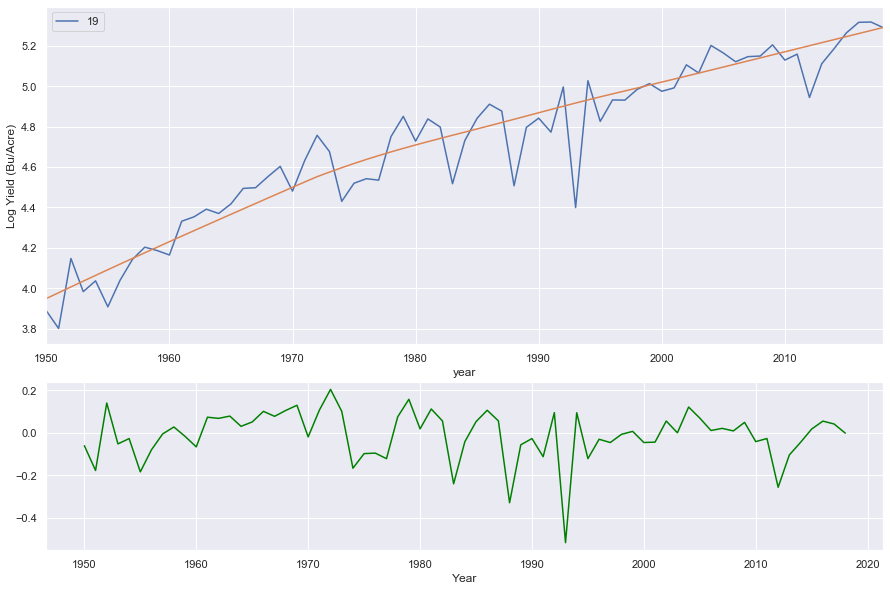

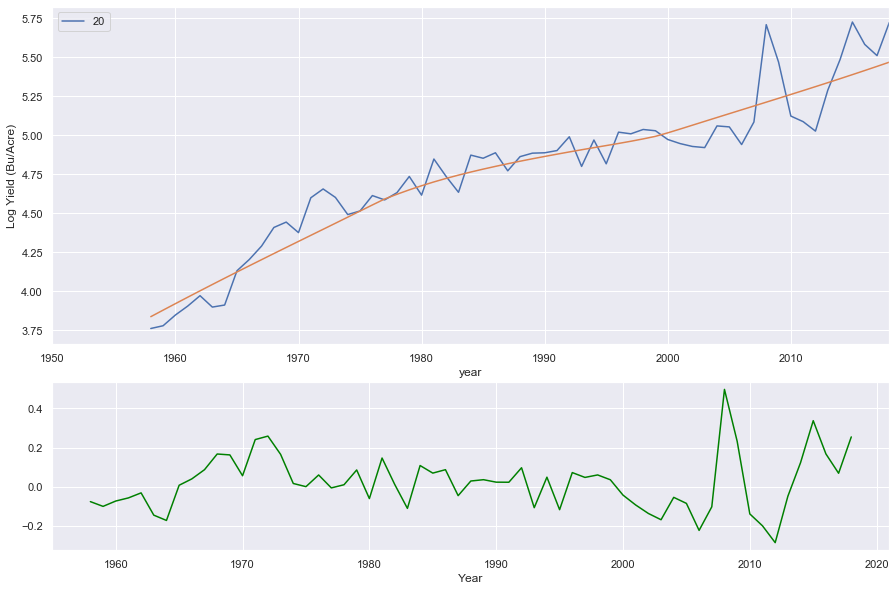

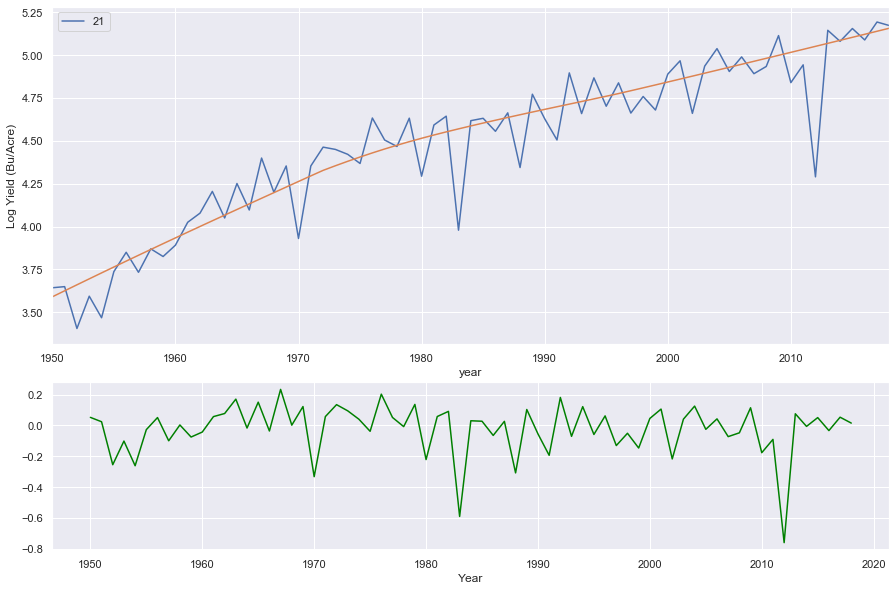

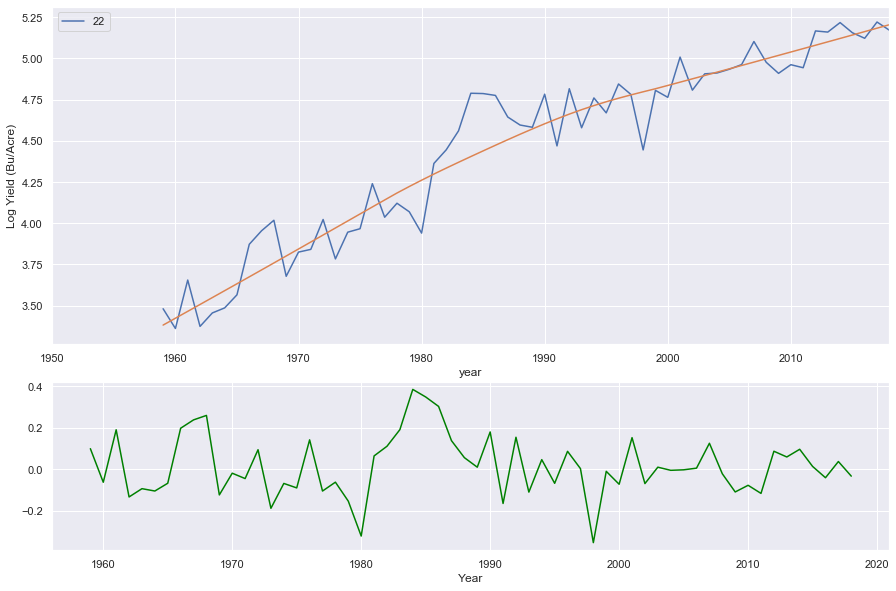

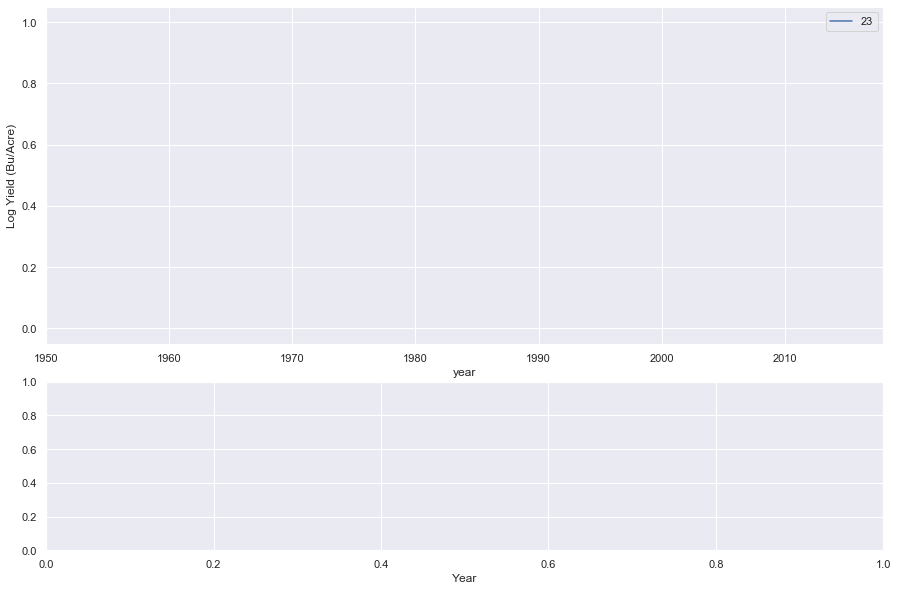

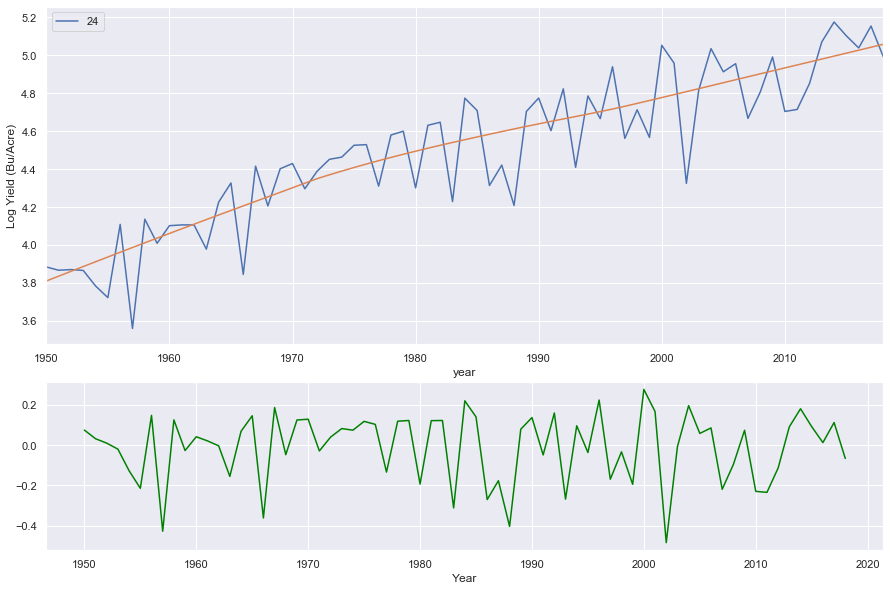

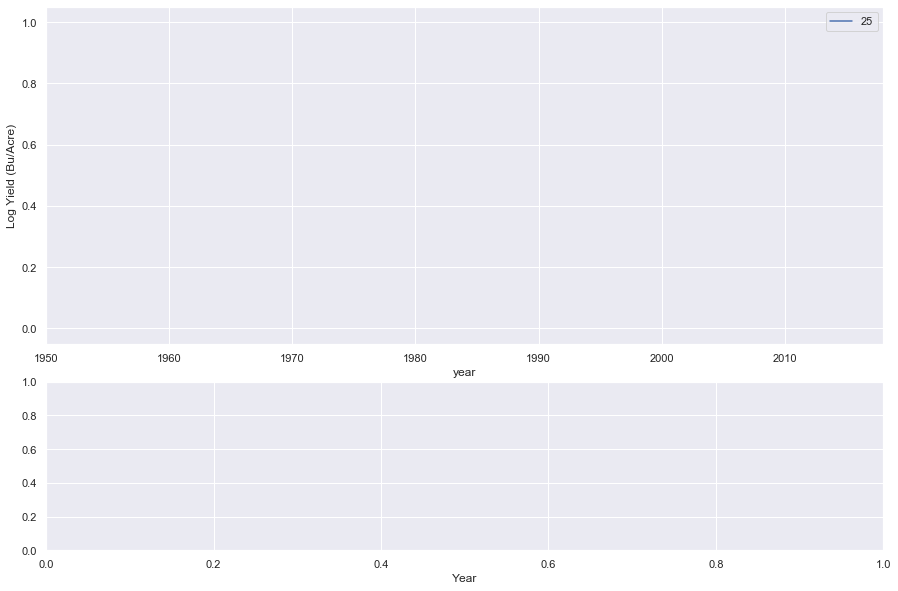

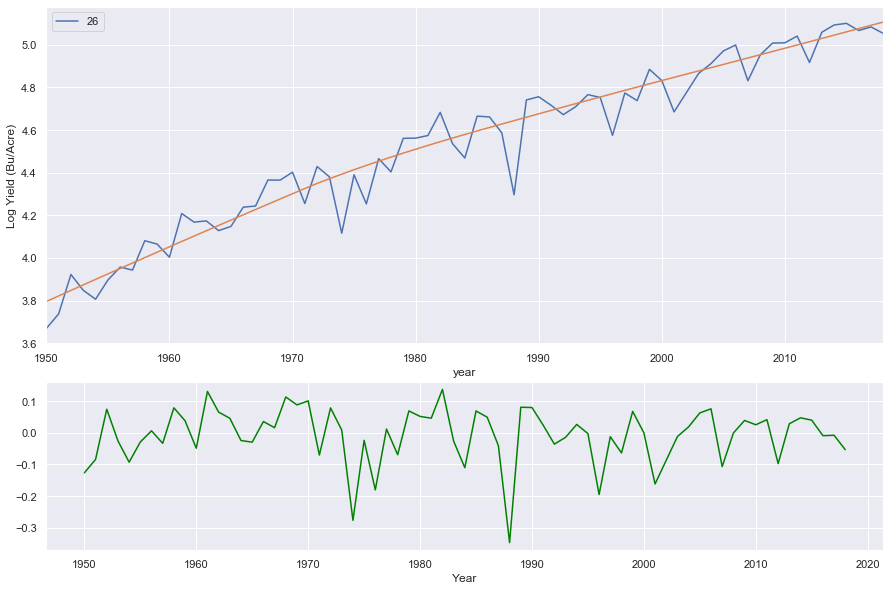

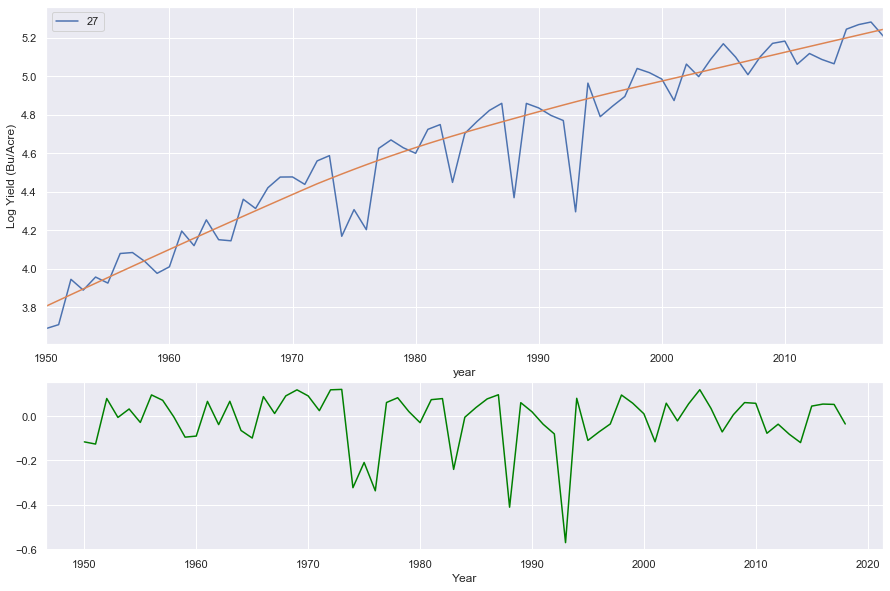

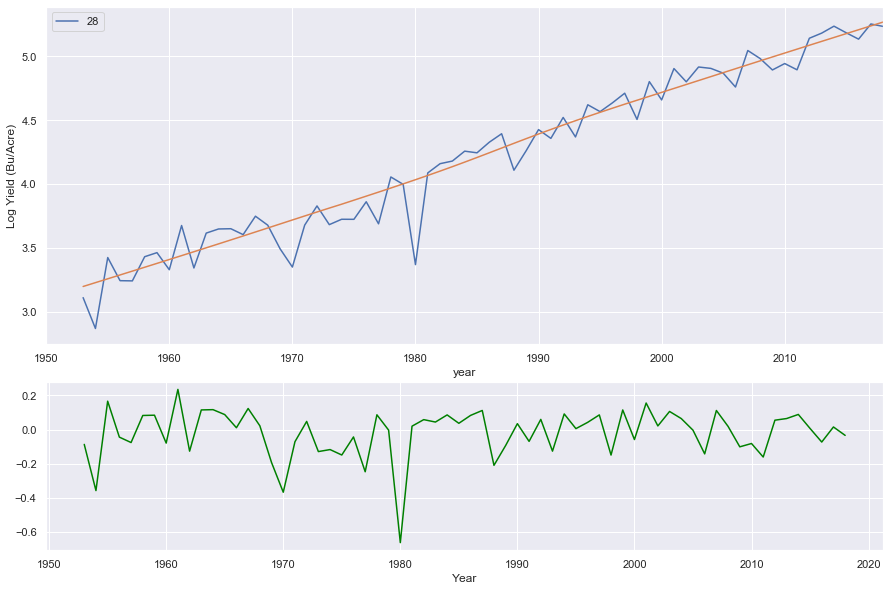

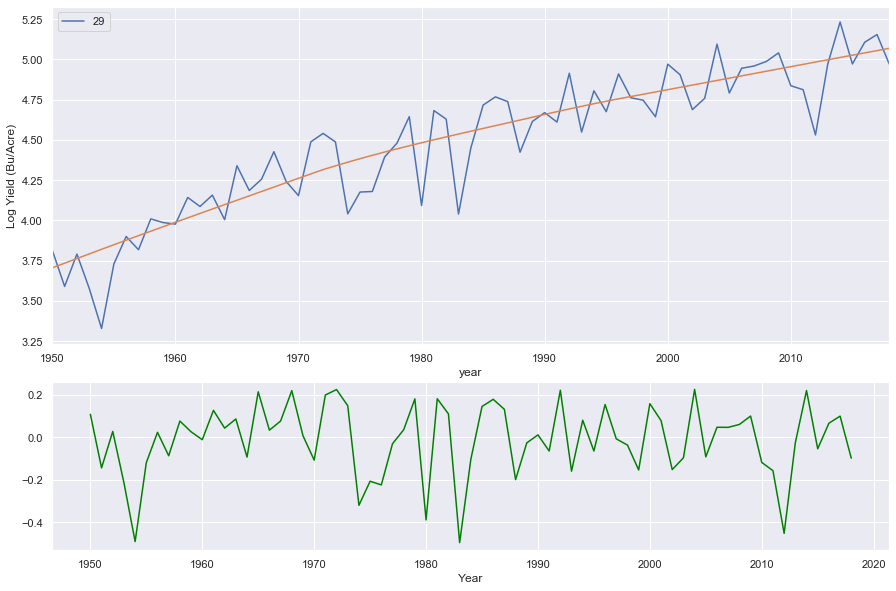

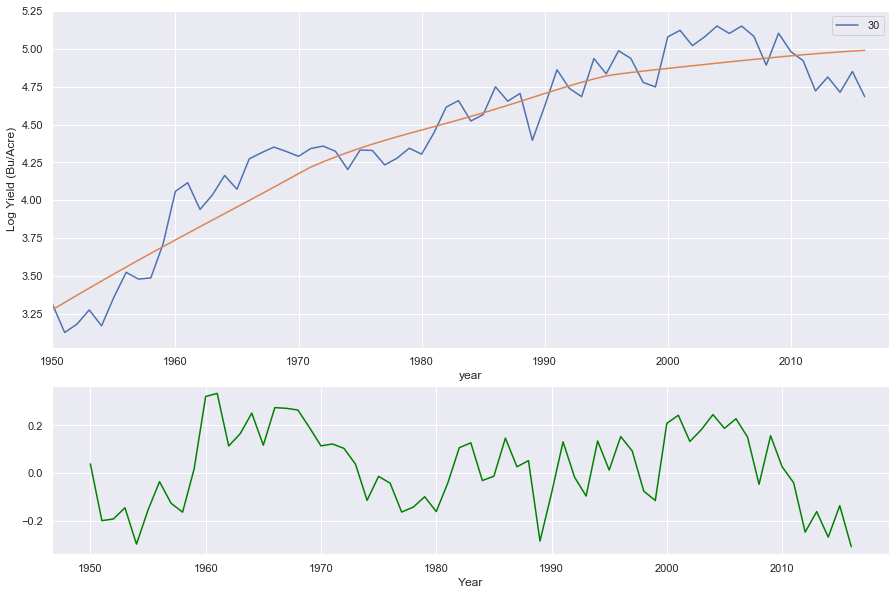

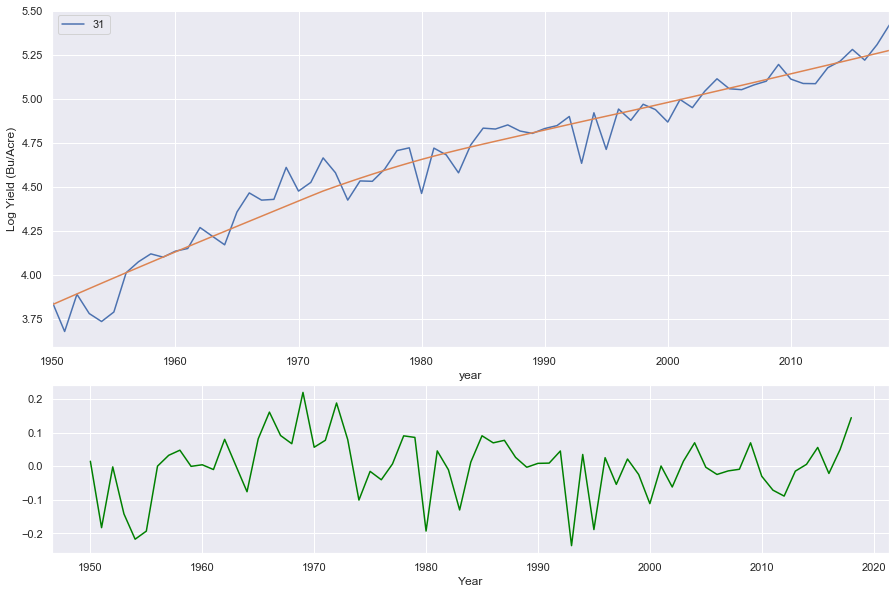

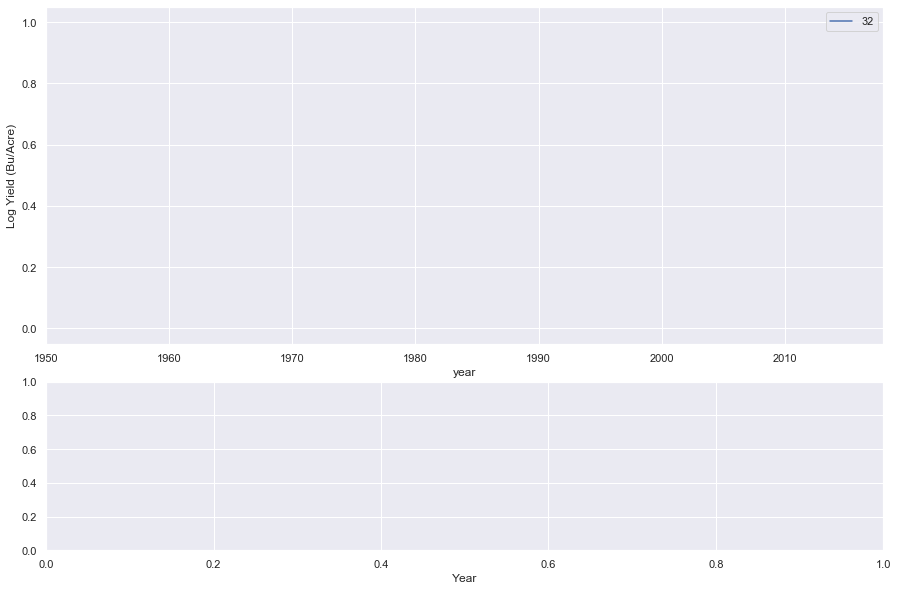

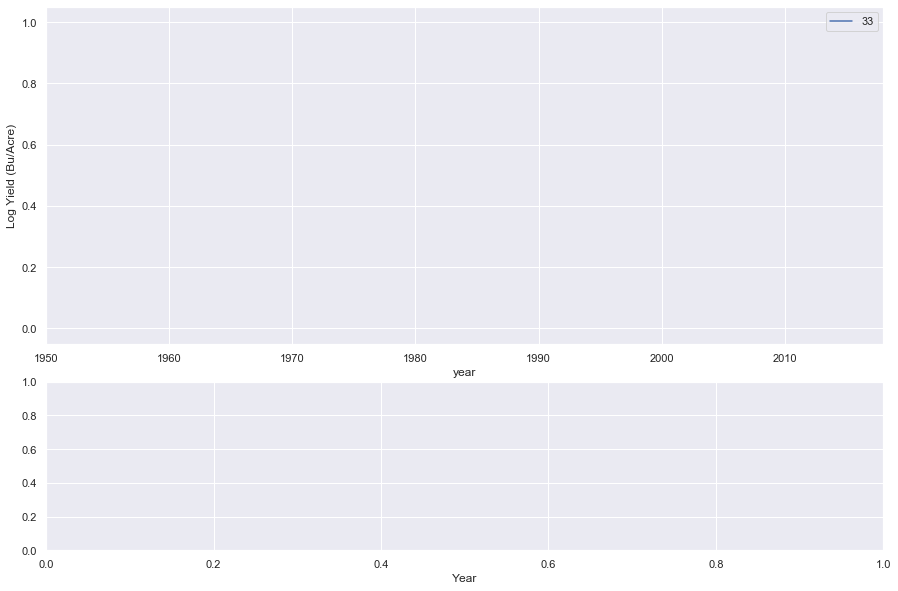

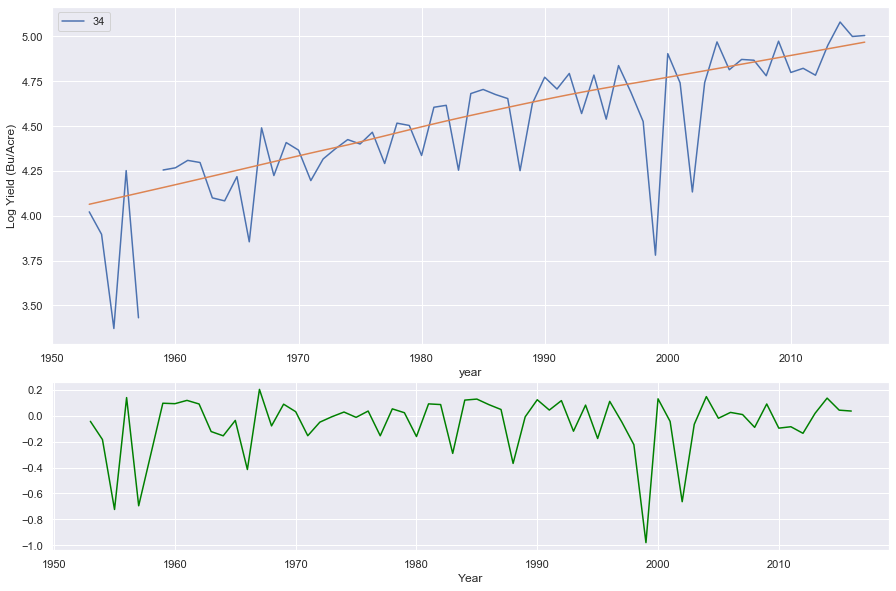

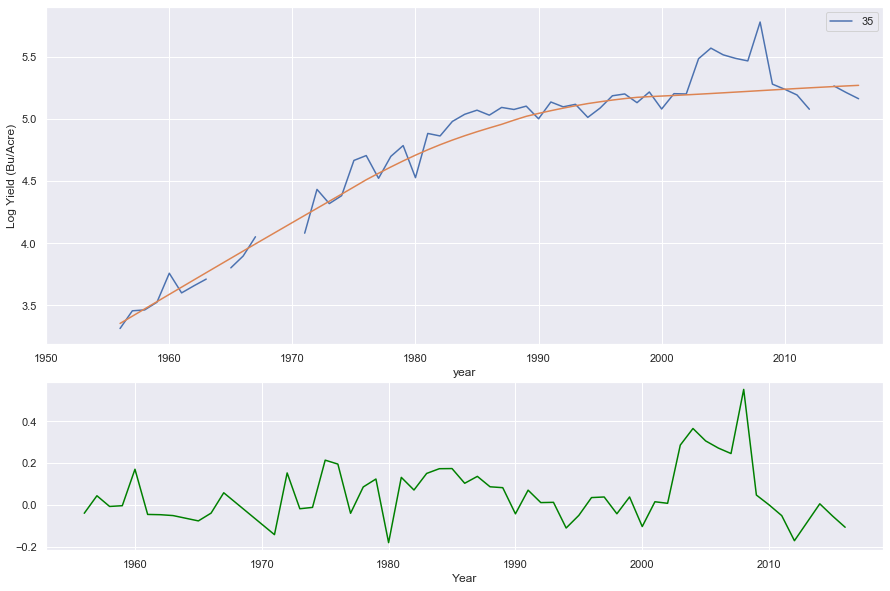

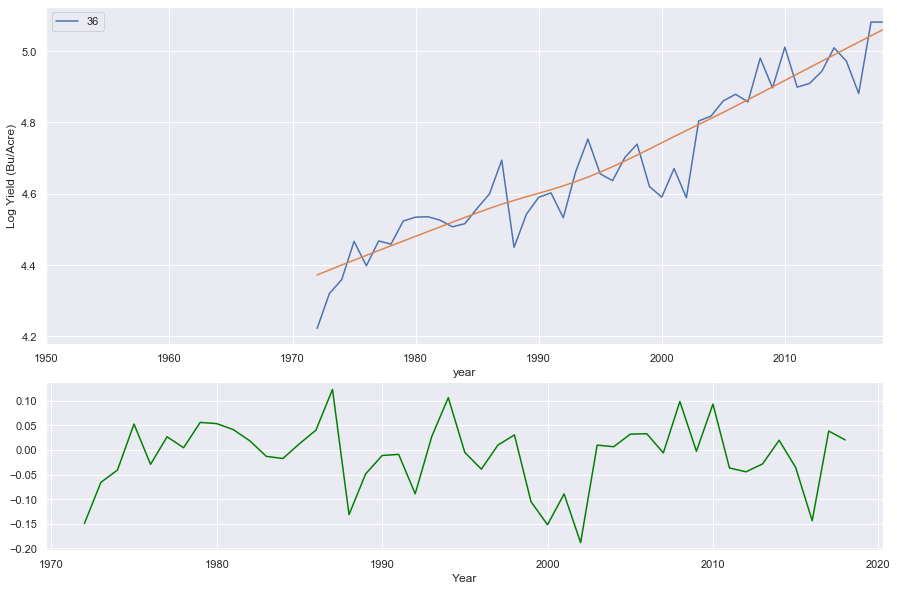

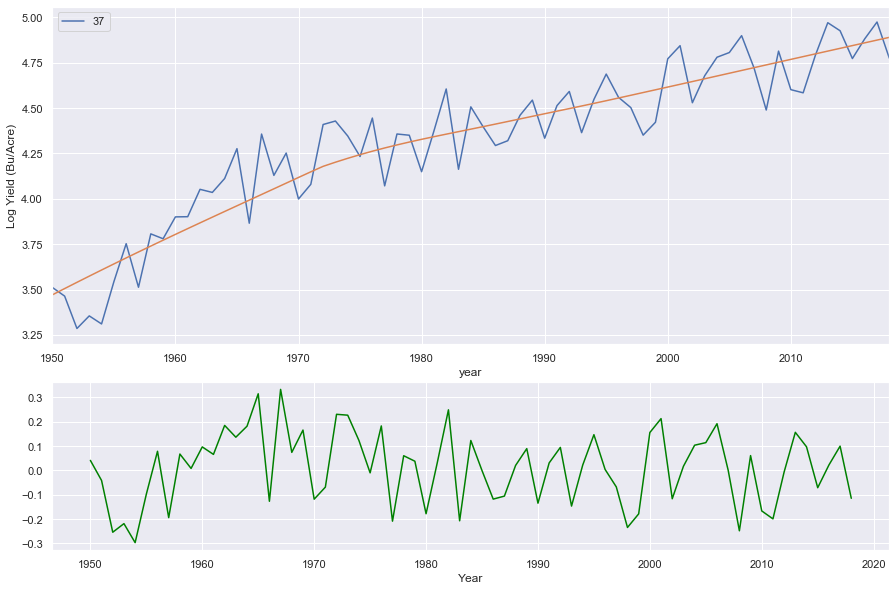

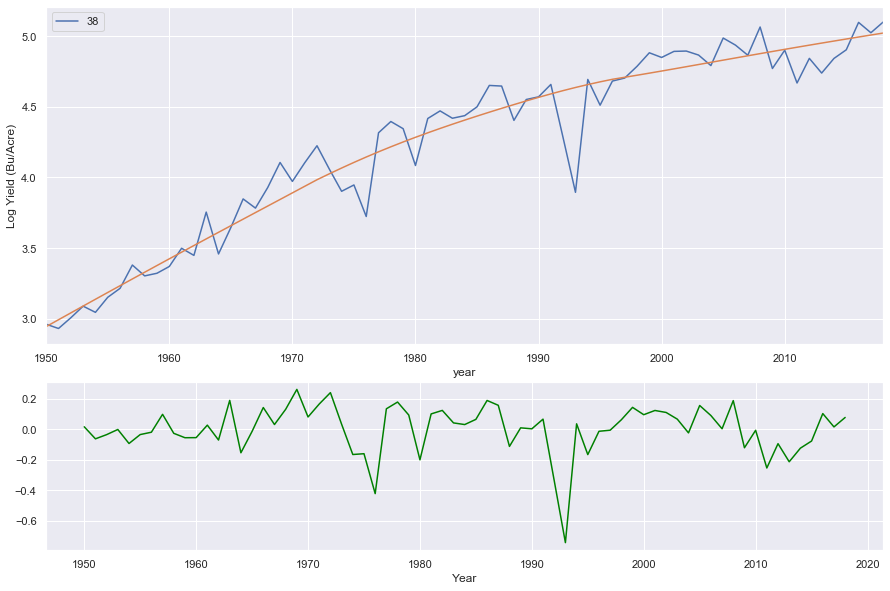

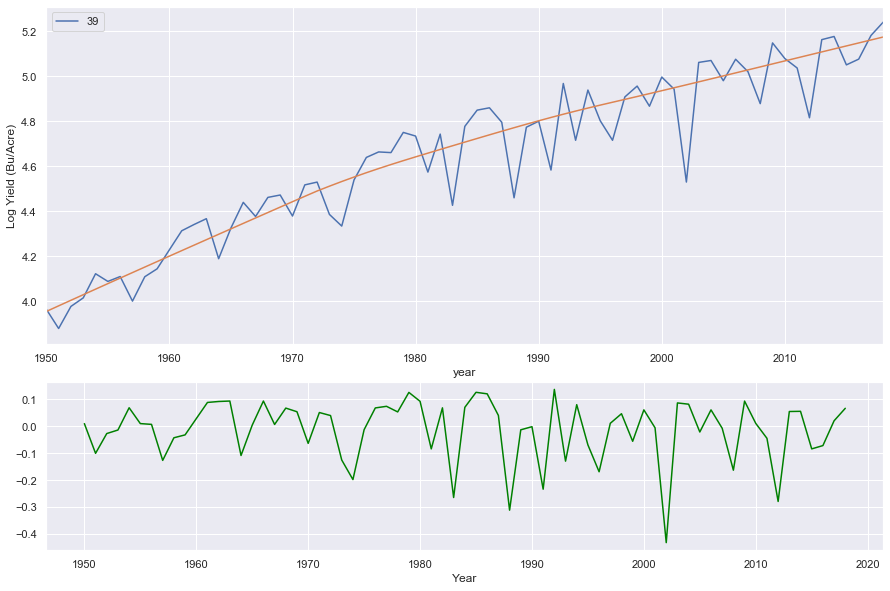

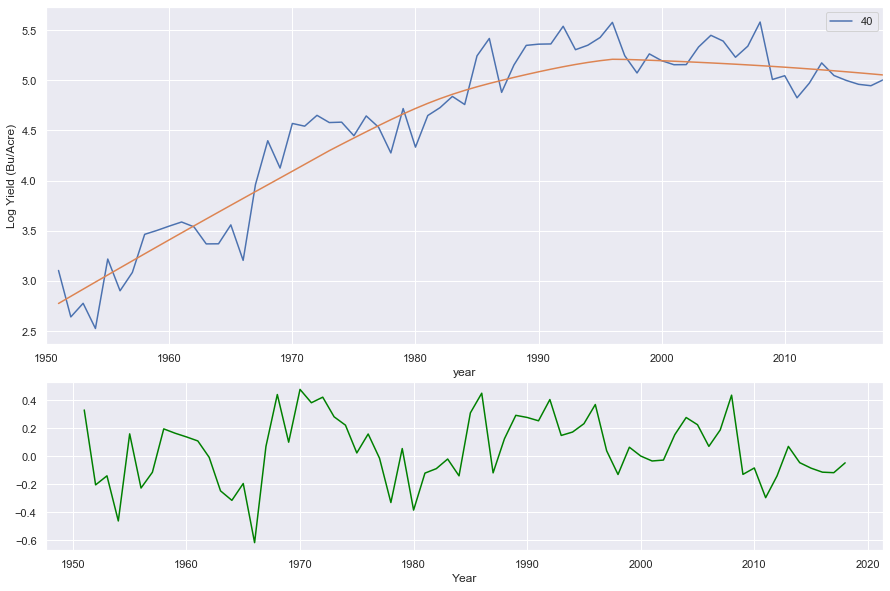

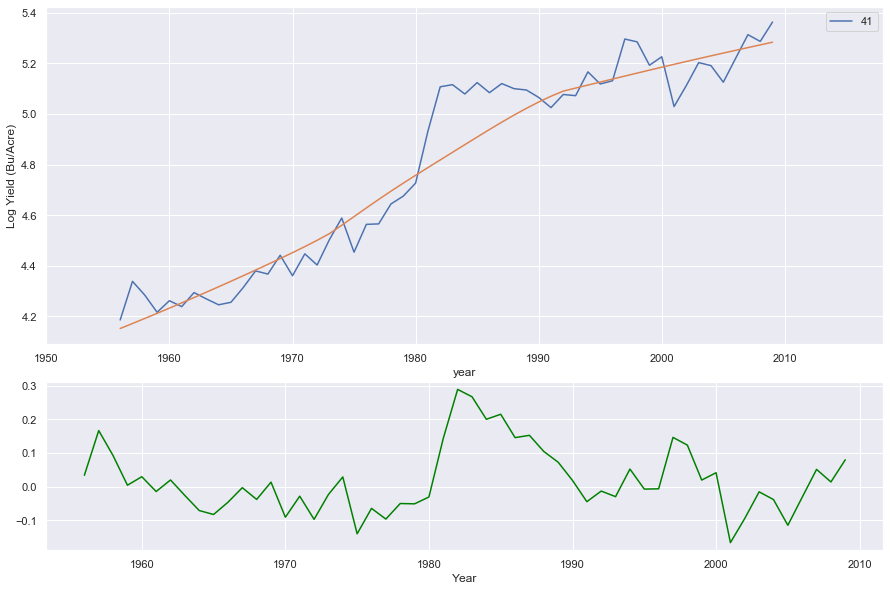

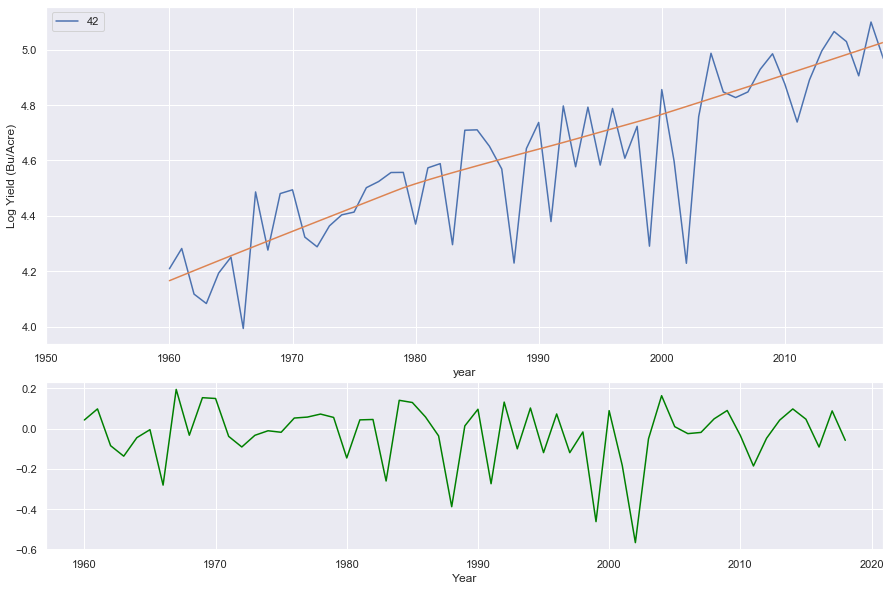

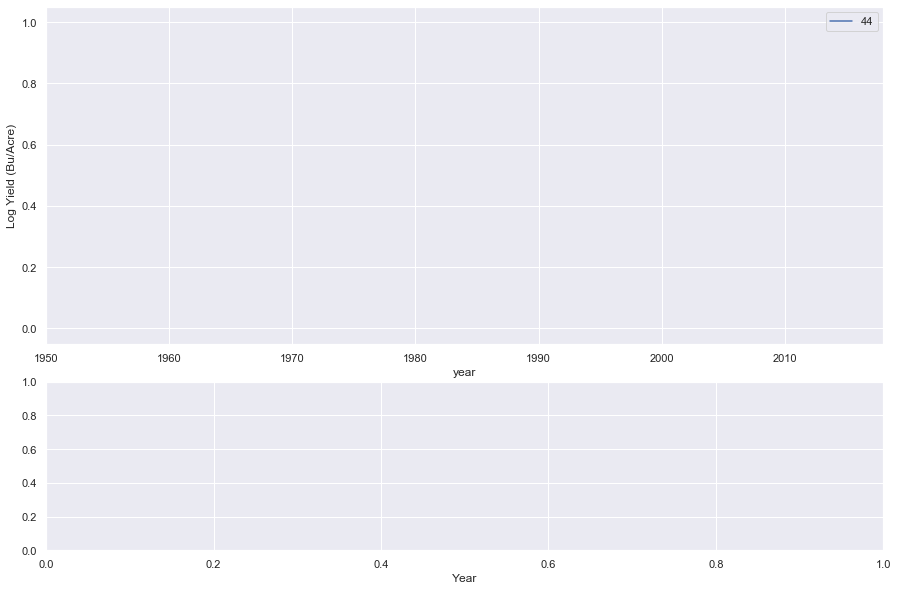

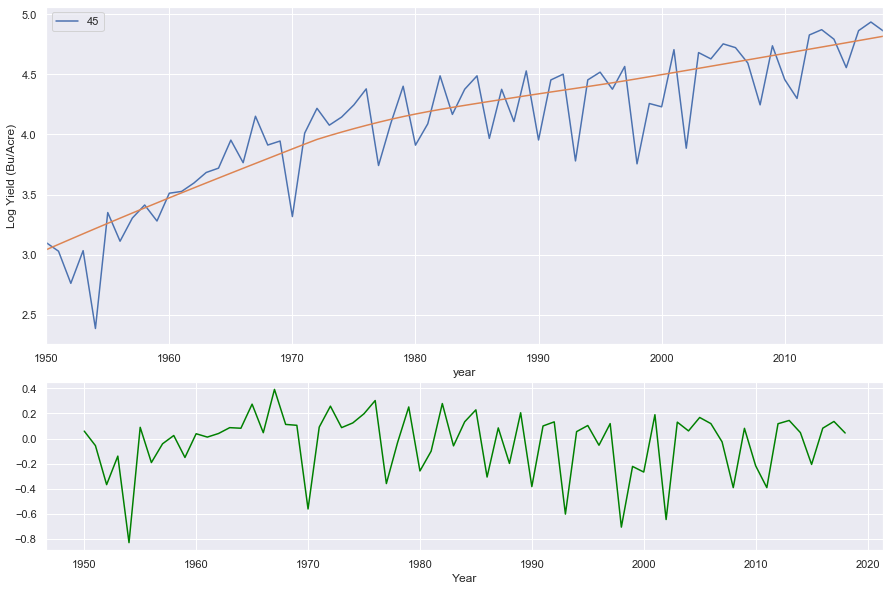

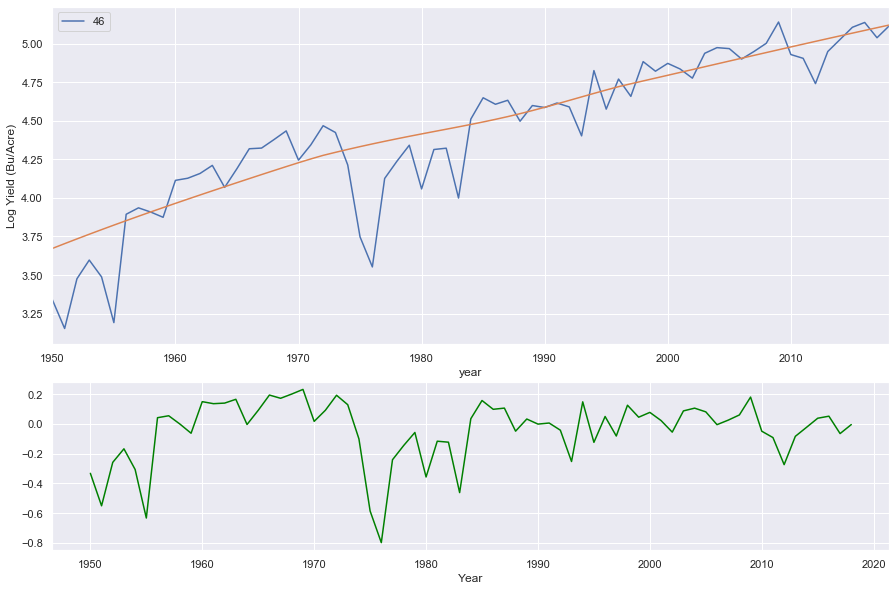

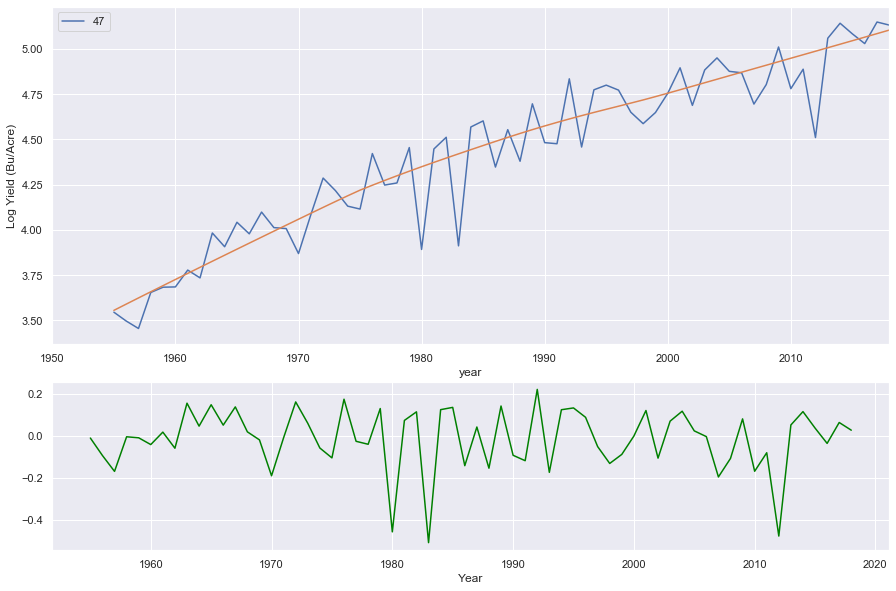

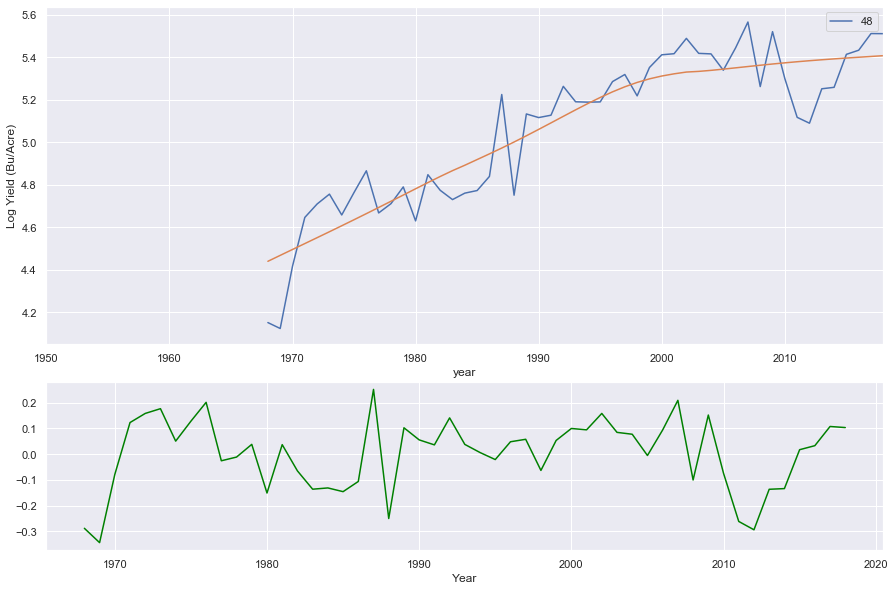

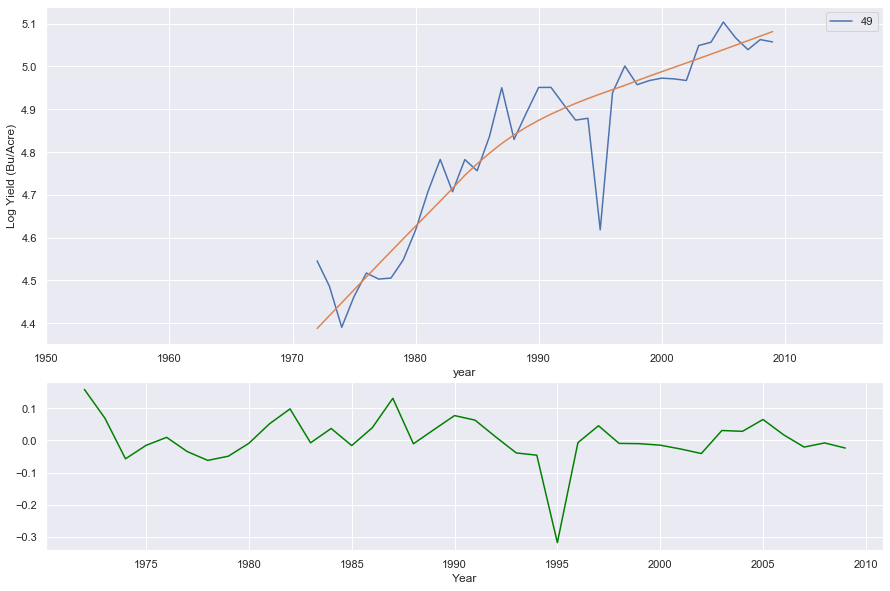

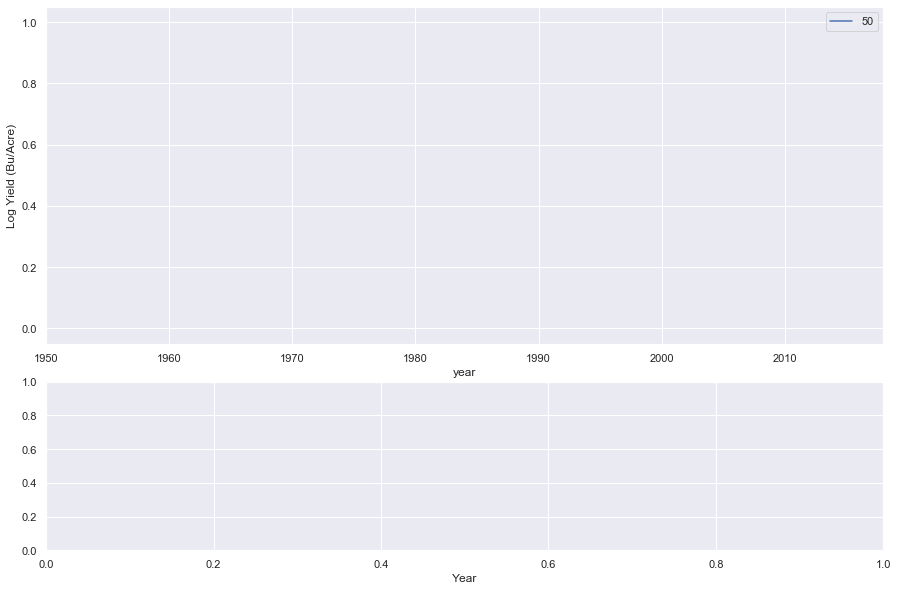

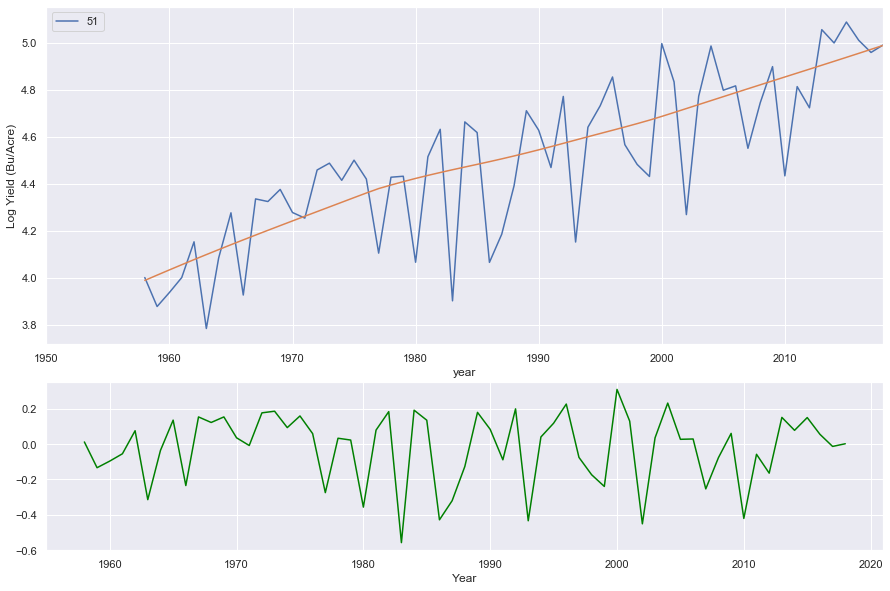

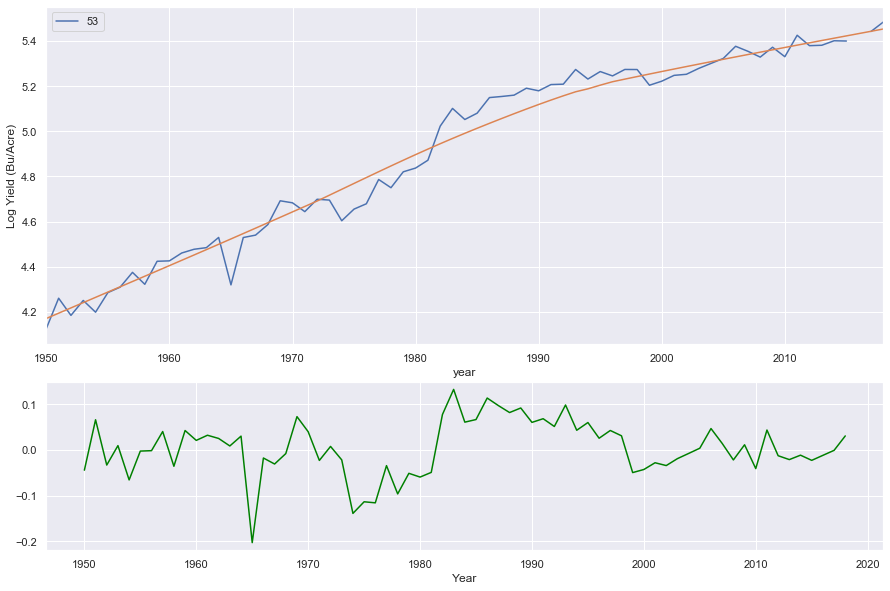

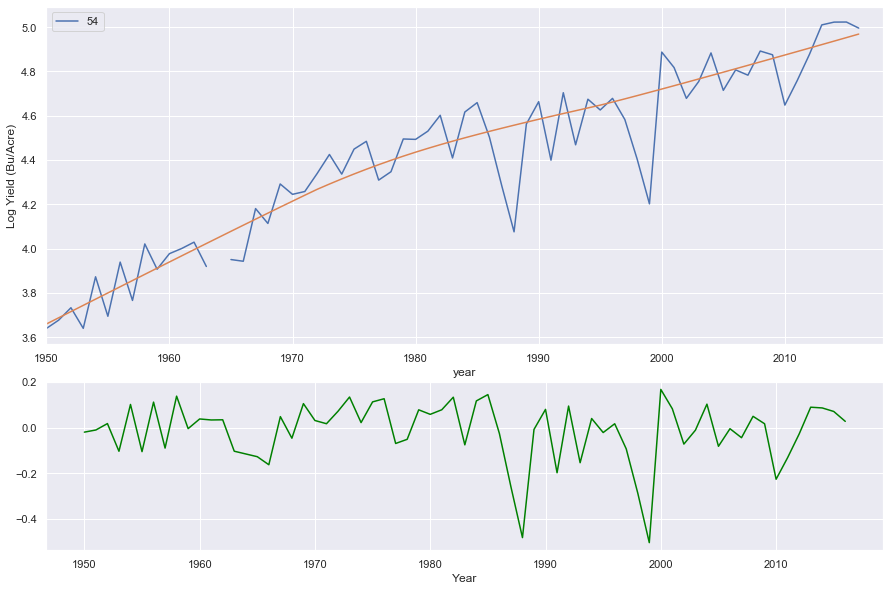

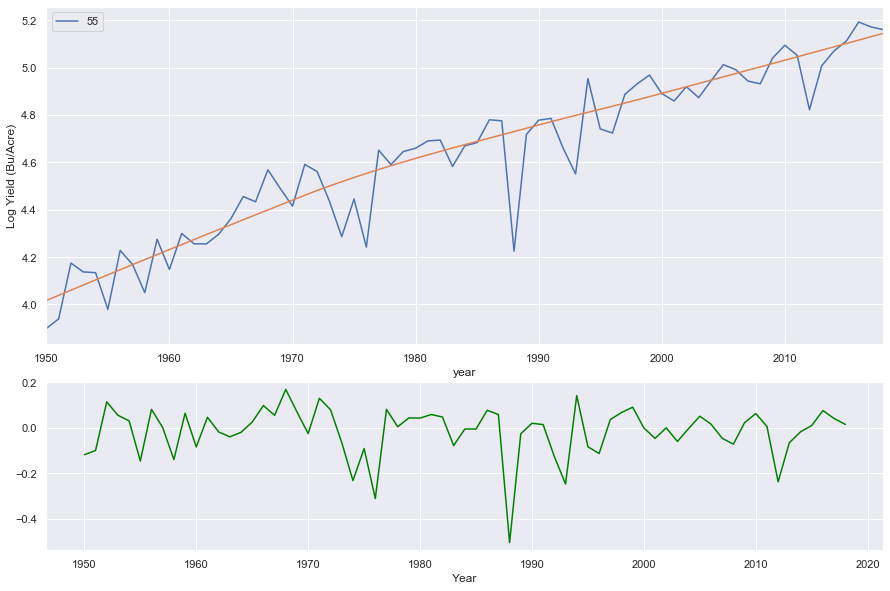

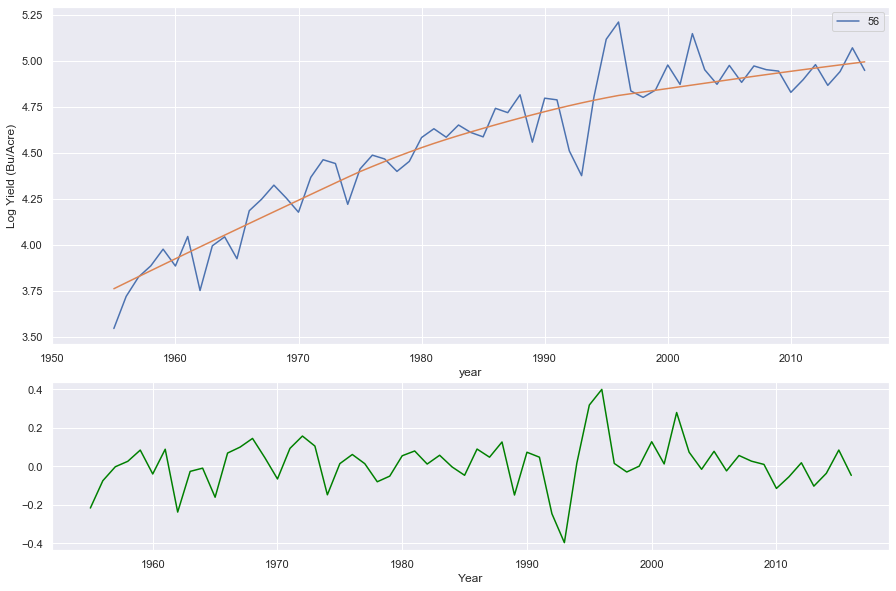

In [32]:
# Plot WEIGHTED log state time series
for state in usda_state.index.unique(level = "state_fips_code"):
    gs = gridspec.GridSpec(2,1, height_ratios=[2,1])
    fig = plt.figure(figsize = (15,10))
    ax1 = plt.subplot(gs[0])
    ax2 = plt.subplot(gs[1])
    fig.subplots_adjust(hspace=0.15)
    ax1.set_ylabel("Log Yield (Bu/Acre)")
    ax2.set_xlabel("Year")
    
    data = usda_state.mask(usda_state == 0).loc[state]
    data.plot(y = "Log_yield", legend = True, label = state, ax = ax1)
    
    if data["state_yield"].sum() > 0.0:
        
        lws_filter = lowess(data["Log_yield"].values, data.index.unique(level = "year").values, missing = "drop")
        ax1.plot(lws_filter[:,0], lws_filter[:,1])
        ax2.plot(lws_filter[:,0], data["Log_yield"].dropna().values - lws_filter[:,1], "green")
        
        temp = pd.DataFrame(data = {"lowess_log_y" : pd.Series(lws_filter[:,1], index = pd.MultiIndex.from_arrays([[state]*len(lws_filter[:,0].astype(int)), lws_filter[:,0].astype(int)]))})
        temp.index.names = ["state_fips_code", "year"]
        usda_state = pd.merge(usda_state, temp, on = ["state_fips_code", "year"], how = "outer")
        usda_state = usda_state.fillna(0)
        usda_state["lowess_log_yield"] = usda_state["lowess_log_yield"] + usda_state["lowess_log_y"]
        del usda_state["lowess_log_y"]
    
    plt.show()

In [33]:
usda_state.head()

state_yield  Log_yield  lowess_log_yield
state_fips_code year                                          
01              1950    24.381012   3.193805          3.068112
                1951    21.730127   3.078700          3.101850
                1952    12.469826   2.523312          3.135566
                1953    23.371898   3.151534          3.169253
                1954    14.037017   2.641698          3.202905

In [34]:
# Save
usda_state.to_csv("./output/usda_state_trends_from_county.csv")

In [35]:
# Merge with county data
del usda_all["state_yield"]
usda_all["state_fips_code"] = usda_all["state_fips_code"].astype(str).str.zfill(2)
usda_all = pd.merge(usda_all, usda_state.reset_index(), on = ["year", "state_fips_code"], how = "outer")
usda_all.rename(columns = {"Value" : "county_yield", "area": "county_area", "Log_yield" : "state_log_yield", "lowess_log_yield" : "state_lowess_log_yield"}, inplace = True)

In [36]:
usda_all.head()

,GEOID,year,state_fips_code,county_code,asd_code,county_yield,county_area,production,county_production_share_in_state,state_yield,state_log_yield,state_lowess_log_yield
0,100140,1950,01,1,40,17.0,29600.0,503200.0,0.008859,24.381012,3.193805,3.068112
1,101140,1950,01,11,40,11.0,24200.0,266200.0,0.004686,24.381012,3.193805,3.068112
2,104740,1950,01,47,40,13.0,44200.0,574600.0,0.010116,24.381012,3.193805,3.068112
3,105140,1950,01,51,40,23.0,38900.0,894700.0,0.015751,24.381012,3.193805,3.068112
4,106340,1950,01,63,40,16.0,23900.0,382400.0,0.006732,24.381012,3.193805,3.068112


In [37]:
# Calculate modelled values
usda_all["county_log_yield"] = usda_all.apply(lambda x: np.log(x["county_yield"]) if x["county_yield"] > 0.0 else 0.0, axis = 1)
usda_all["target_Value"] = usda_all["county_log_yield"] - usda_all["state_lowess_log_yield"]

In [38]:
usda_all.head()

,GEOID,year,state_fips_code,county_code,asd_code,county_yield,county_area,production,county_production_share_in_state,state_yield,state_log_yield,state_lowess_log_yield,county_log_yield,target_Value
0,100140,1950,01,1,40,17.0,29600.0,503200.0,0.008859,24.381012,3.193805,3.068112,2.833213,-0.234899
1,101140,1950,01,11,40,11.0,24200.0,266200.0,0.004686,24.381012,3.193805,3.068112,2.397895,-0.670217
2,104740,1950,01,47,40,13.0,44200.0,574600.0,0.010116,24.381012,3.193805,3.068112,2.564949,-0.503163
3,105140,1950,01,51,40,23.0,38900.0,894700.0,0.015751,24.381012,3.193805,3.068112,3.135494,0.067382
4,106340,1950,01,63,40,16.0,23900.0,382400.0,0.006732,24.381012,3.193805,3.068112,2.772589,-0.295523
